## STEU Analysis

In [1]:
import pandas as pd 
gold = pd.read_csv("data/steu-categories.csv")
options = pd.read_csv("data/steu-abilities-test.csv")
gemma = pd.read_csv("results/gemma-2-27b-it/steu-results.csv")
gpt4 = pd.read_csv("results/gpt4o-mini/steu-results.csv")
llama = pd.read_csv("results/Meta-Llama-3.1-70B-Instruct/steu-results.csv")
mixtral = pd.read_csv("results/Mixtral-8x7B-Instruct-v0.1/steu-results.csv")

llm_map = {"gemma": gemma, "gpt4": gpt4, "llama": llama, "mixtral": mixtral}
llms = list(llm_map.keys())

llm_factors = {
    "gemma": { "wellbeing": 4.67, "self_control": 4.5, "emotionality": 4.62, "sociability": 4.67 }, 
    "gpt4": {"wellbeing": 4.33, "self_control": 4.33, "emotionality": 4.0, "sociability": 4.83},
    "llama": {"wellbeing": 4.83, "self_control": 3.33, "emotionality": 3.0, "sociability": 3.67},
    "mixtral": {"wellbeing": 4.83, "self_control": 3.83, "emotionality": 3.5, "sociability": 3.67}
}

In [2]:
import math

reg_rows = []
for i, row in gold.iterrows():

    if i == 0:
        continue
       
    for llm in llms:
        if str(llm_map[llm].loc[i, "pred"]) == "nan":
            continue
        
        o = options.loc[i]
        pred_option = llm_map[llm].loc[i, "pred"]
        pred = llm_map[llm].loc[i, pred_option]

        r = {
            "situation": row["situation"],
            "model": llm, 
            "is_correct": llm_map[llm].loc[i, "is_correct"],
            "answer": row["answer"],
            "pred": pred,
            "ekman": row["ekman"].lower(),
            "complex": row["complex"].lower(),
            "explanation": llm_map[llm].loc[i, "explanation"]
            
            # "wellbeing": llm_factors[llm]["wellbeing"],
            # "self_control": llm_factors[llm]["self_control"],
            # "emotionality": llm_factors[llm]["emotionality"],
            # "sociability": llm_factors[llm]["sociability"],
        }
        
        reg_rows.append(r)
reg = pd.DataFrame(reg_rows)

In [25]:
l = list(zip(reg["situation"].unique(), range(0, len(reg["situation"].unique()))))
keys = pd.DataFrame(l,columns=["situation", "q-id"])

results = pd.merge(reg, keys, how="left")

bad = results.query("is_correct == 0").sample(20)

In [27]:
bad.to_csv("human-study-examples.csv")

### Stats

In [67]:
reg.to_csv("results/all-results-merged.csv", index=False)

In [ ]:
filter = [
    'Sad', 'Pride', 'Relief', 'Joy','Gratitude', 'Distressed', 
    'Hope', 'Contempt','Frustrated', 'Scared', 'Dislike', 'Angry'
]

reg_filt = reg.query("answer in @filter") 

reg_filt[["answer", "ekman"]].groupby(["answer", "ekman"]).mean()

In [ ]:
ekman_rev_map  = {
    'Angry': 'anger', 'Contempt': 'anger', 'Dislike': 'anger',
    'Distressed': 'fear', 'Frustrated': 'anger',
    'Gratitude': 'happiness', 'Hope': 'happiness', 'Joy': 'happiness',
    'Pride': 'happiness', 'Relief': 'happiness', 'Sad': 'sadness', "scared": 'fear'
}

reg_filt["pred_ekman"] = reg_filt["pred"].map(ekman_rev_map)

In [48]:
filter = [
    'Sad', 'Pride', 'Relief', 'Joy',
    'Gratitude', 'Distressed', 'Hope', 'Contempt',
    'Frustrated', 'Scared', 'Dislike', 'Angry',
]
cf = reg.query("answer in @filter")[["pred", "answer"]]

cf2 = reg_filt[["pred_ekman", "ekman"]]

In [59]:
cf2 = cf2.dropna()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Convert to DataFrame for better handling with seaborn
# emotion_labels = ['Sad', 'Pride', 'Relief', 'Joy', 'Gratitude', 'Distressed', 'Hope',
#                   'Contempt', 'Frustrated', 'Scared', 'Dislike', 'Angry']

emotion_labels = ['sadness', 'happiness', 'fear', 'anger', 'disgust']

# Create the confusion matrix, explicitly passing the full set of labels
conf_matrix = confusion_matrix(cf2['pred_ekman'], cf2['ekman'], labels=emotion_labels)

# Convert the confusion matrix into a DataFrame for easier handling with seaborn
conf_matrix_df = pd.DataFrame(conf_matrix, index=emotion_labels, columns=emotion_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability
plt.yticks(rotation=0)  # Keep y-axis labels horizontal
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

In [24]:
merged_rows = []
for i, row in gold.iterrows():

    if i == 0:
        continue

    row = row.to_dict()
    for llm in llms:
        row[f"{llm}-pred"] = llm_map[llm].loc[i, "pred"]
        row[f"{llm}-is-correct"] = llm_map[llm].loc[i, "is_correct"]
        row[f"{llm}-explanation"] = llm_map[llm].loc[i, "explanation"]
    
    all_correct = int(row["gemma-is-correct"] and row["gpt4-is-correct"] and row["llama-is-correct"] and row["mixtral-is-correct"])
    all_incorrect = int(row["gemma-is-correct"] == 0 and row["gpt4-is-correct"] == 0 and row["llama-is-correct"] == 0 and row["mixtral-is-correct"] == 0)
    row["all_correct"] = all_correct
    row["all_incorrect"] = all_incorrect
    merged_rows.append(row)

results_merged = pd.DataFrame(merged_rows)

In [ ]:
results_merged.mean()

In [ ]:
results_merged.groupby("ekman").mean()

In [ ]:
results_merged.groupby("complex").mean()

In [29]:
results_merged.to_csv("results/steu-results-merged.csv", index=False)

## Merged Results

In [146]:
import pandas as pd 

emotions = ['Hope', 'Contempt', 'Frustrated', 'Sad', 
            'Relief', 'Scared', 'Pride', 'Distressed', 
            'Dislike', 'Gratitude', 'Joy','Angry']

r = pd.read_csv("results/all-results-merged.csv")
m = r.query("answer in @emotions")

clean_rows = []
for i, r in m.iterrows():
    row = r.to_dict()
    if row["is_correct"] == 1:
        row["pred_ekman"] = row["ekman"]
        row["Plausible"] = 1
    clean_rows.append(row) 

df = pd.DataFrame(clean_rows)

In [148]:
df["Plausible"].mean()

0.9776119402985075

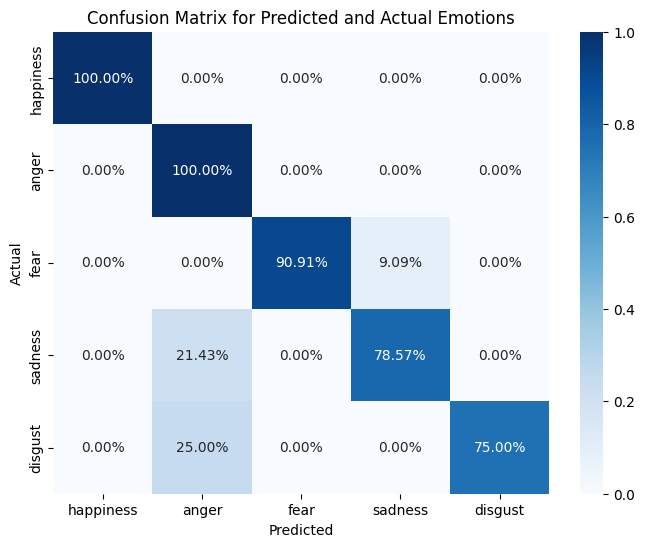

In [149]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

df = df[["pred_ekman", "ekman"]]    
# Define labels
labels = ['happiness', 'anger', 'fear', 'sadness', 'disgust']

# Create confusion matrix
cm = confusion_matrix(df['ekman'], df['pred_ekman'], labels=labels, normalize='true')

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Predicted and Actual Emotions')
plt.show()

## TIEQUE

In [91]:
import pandas as pd
import numpy as np

gemma = pd.read_csv("results/gemma-2-27b-it/teique-results.csv")
gpt4 = pd.read_csv("results/gpt4o-mini/teique-results.csv")
llama = pd.read_csv("results/Meta-Llama-3.1-70B-Instruct/teique-results.csv")
mixtral = pd.read_csv("results/Mixtral-8x7B-Instruct-v0.1/teique-results.csv")

llm_map = {"gemma": gemma, "gpt4": gpt4, "llama": llama, "mixtral": mixtral}
llms = list(llm_map.keys())

merged_rows = []
for i, r in gemma.iterrows():
    
    scores = [r["score"], gpt4.loc[i, "score"], llama.loc[i, "score"], mixtral.loc[i, "score"]]
    std = np.std(scores)
    new_row = {
        "tqn": r['tqn'],
        "statement": r['statement'],
        "gemma_score": r["score"],
        "gemma_response": r["response"],
        "gpt4o_score": gpt4.loc[i, "score"],
        "gpt4o_response": gpt4.loc[i, "response"],
        "llama_score": llama.loc[i, "score"],
        "llama_response": llama.loc[i, "response"],
        "mixtral_score": mixtral.loc[i, "score"],
        "mixtral_response": mixtral.loc[i, "response"],
        "std": std
    }

    merged_rows.append(new_row)

merged = pd.DataFrame(merged_rows)

In [93]:
wellbeing_idxs = [5, 20, 9, 24, 12, 27]
self_control_idxs = [4, 19, 7, 22, 15, 30]
emotionality_idxs = [1, 16, 2, 17, 8, 23, 13, 28 ]
sociability_idxs = [6, 21, 10, 25, 11, 26]

def map_idx(tqn):
    if tqn in wellbeing_idxs:
        return "wellbeing"
    elif tqn in self_control_idxs:
        return "self control"
    elif tqn in emotionality_idxs:
        return "emotionality"
    elif tqn in sociability_idxs:
        return "sociability"
    
merged["factor"] = merged["tqn"].apply(map_idx)

In [95]:
merged.to_csv("results/teique-results-merged.csv", index=False)

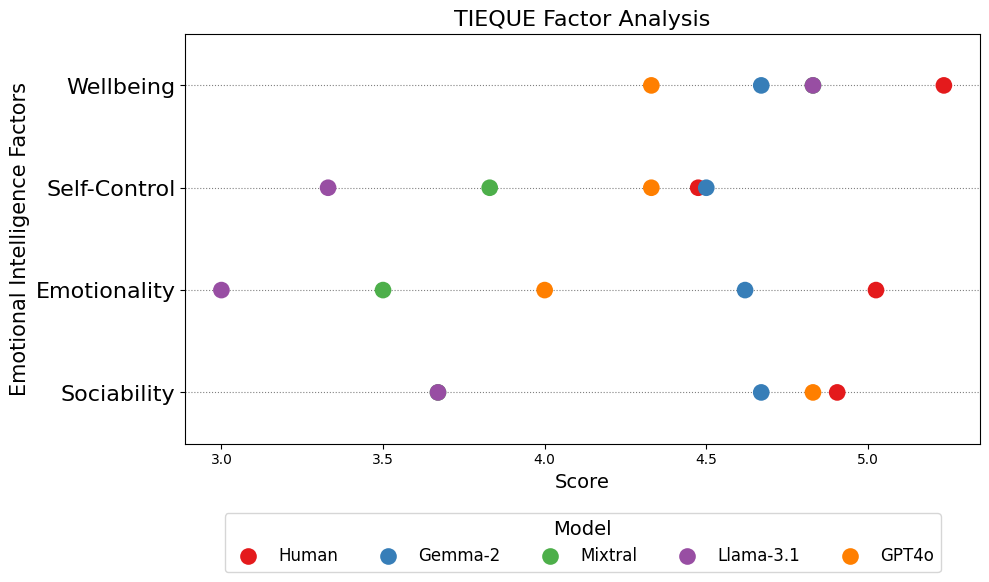

In [132]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Data from the table
data = {
    'Model': ['Human', 'Human', 'Human', 'Human', 'Gemma-2', 'Gemma-2', 'Gemma-2', 'Gemma-2', 'Mixtral', 'Mixtral', 'Mixtral', 'Mixtral',
              'Llama-3.1', 'Llama-3.1', 'Llama-3.1', 'Llama-3.1', 'GPT4o', 'GPT4o', 'GPT4o', 'GPT4o'],
    'Factor': ['Wellbeing', 'Self-Control', 'Emotionality', 'Sociability', 'Wellbeing', 'Self-Control', 'Emotionality', 'Sociability',
               'Wellbeing', 'Self-Control', 'Emotionality', 'Sociability', 'Wellbeing', 'Self-Control', 'Emotionality', 'Sociability',
               'Wellbeing', 'Self-Control', 'Emotionality', 'Sociability'],
    'Score': [5.235, 4.475, 5.025, 4.905, 4.67, 4.5, 4.62, 4.67, 4.83, 3.83, 3.5, 3.67, 4.83, 3.33, 3, 3.67, 4.33, 4.33, 4, 4.83]
}

# Creating a DataFrame
df = pd.DataFrame(data)

# Creating the dot plot
plt.figure(figsize=(10, 6))
sns.stripplot(data=df, x='Score', y='Factor', hue='Model', jitter=0.0, size=12, palette='Set1')  # Increased dot size

# Adding dotted grid lines for the y-axis
plt.grid(axis='y', linestyle=':', color='gray')

# Customizing the plot
plt.title('TIEQUE Factor Analysis', fontsize=16)  # Increase title font size
plt.xlabel('Score', fontsize=14)  # Increase x-axis label font size
plt.ylabel('Emotional Intelligence Factors', fontsize=15)  # Increase y-axis label font size

plt.yticks(fontsize=16)

# Moving the legend below the plot and putting all legend items in one row
plt.legend(title='Model', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=len(df['Model'].unique()), fontsize=12, title_fontsize=14)

# Display the plot with adjusted layout
plt.tight_layout()
plt.show()



In [133]:
import pandas as pd

# Data for LLMs
data_llms = {
    'Model': ['Gemma-2', 'Gemma-2', 'Gemma-2', 'Gemma-2', 
              'Mixtral', 'Mixtral', 'Mixtral', 'Mixtral',
              'Llama-3.1', 'Llama-3.1', 'Llama-3.1', 'Llama-3.1', 
              'GPT4o', 'GPT4o', 'GPT4o', 'GPT4o'],
    'Std Dev': [2.16, 1.38, 1.6, 1.03, 
                2.99, 2.04, 1.69, 1.86, 
                2.32, 1.51, 1.77, 1.86, 
                1.86, 0.82, 1.2, 0.98]
}

# Creating a DataFrame for LLMs
df_llms = pd.DataFrame(data_llms)

# Calculating the average standard deviation
average_std_dev = df_llms['Std Dev'].mean()

# Display the result
print("Average Standard Deviation for LLMs:", average_std_dev)

Average Standard Deviation for LLMs: 1.691875


In [134]:
import pandas as pd

# Data for Humans
data_humans = {
    'Model': ['Human', 'Human', 'Human', 'Human'],
    'Std Dev': [0.83, 0.75, 0.71, 0.74]  # Standard deviations for Human factors
}

# Creating a DataFrame for Humans
df_humans = pd.DataFrame(data_humans)

# Calculating the average standard deviation
average_std_dev_humans = df_humans['Std Dev'].mean()

# Display the result
print("Average Standard Deviation for Humans:", average_std_dev_humans)


Average Standard Deviation for Humans: 0.7575000000000001


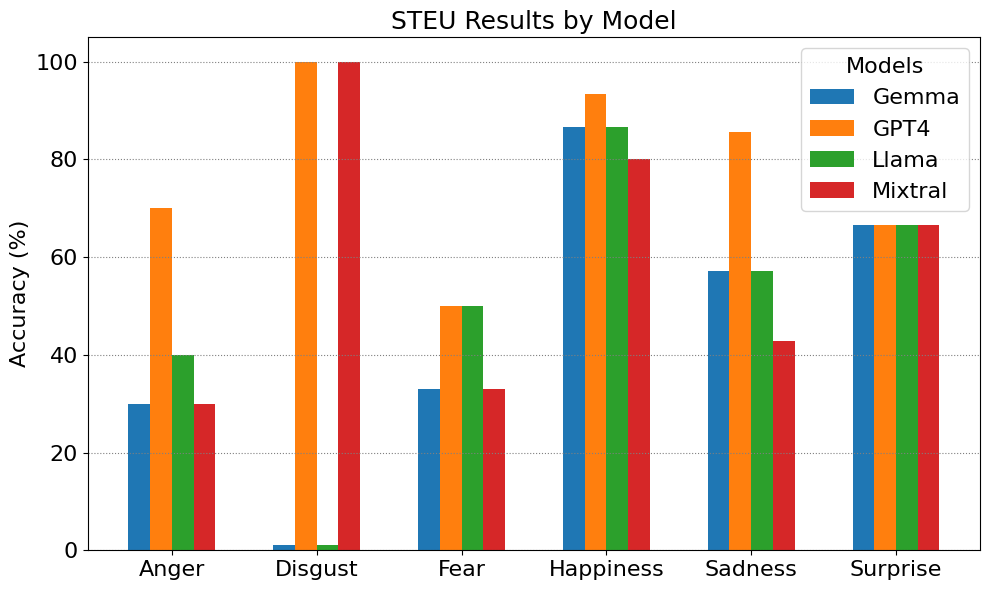

In [144]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['Gemma', 'GPT4', 'Llama', 'Mixtral']
emotions = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise']
scores = [
    [0.3, 0.01, 0.33, 0.866, 0.571, 0.666],  # Gemma
    [0.7, 1.0, 0.5, 0.933, 0.857, 0.666],  # GPT4
    [0.4, 0.01, 0.5, 0.866, 0.571, 0.666],  # Llama
    [0.3, 1.0, 0.33, 0.8, 0.429, 0.666]    # Mixtral
]

# Convert scores to percentages
scores_percent = np.array(scores) * 100

# Create the bar chart
bar_width = 0.15
x = np.arange(len(emotions))

fig, ax = plt.subplots(figsize=(10, 6))
for i, model in enumerate(models):
    ax.bar(x + i * bar_width, scores_percent[i], width=bar_width, label=model)

# Customizing the plot
#ax.set_xlabel('Emotions', fontsize=16)
ax.set_ylabel('Accuracy (%)', fontsize=16)
ax.set_title('STEU Results by Model', fontsize=18)
ax.set_xticks(x + bar_width * (len(models) - 1) / 2)
ax.set_xticklabels(emotions, fontsize=16)
ax.legend(title='Models', fontsize=16, title_fontsize='16')

plt.grid(axis='y', linestyle=':', color='gray')

# Increase font size for axes
ax.tick_params(axis='both', which='major', labelsize=16)

# Display the plot
plt.tight_layout()
plt.show()